# Basic GP optimizer


**INSTRUCTIONS FOR USE:**
This code will run an offline example as-is without any input arguments. Simply run the file in python.

In order to use it on a specific machine:

- First read 'HOW_TO_USE.txt' and complete steps 1 and 2
   *Note*: It is recommended to make a copy of this file with a unique name and open it so that you don't edit the original.
   
- Then, on line 23 of this file, select the name of your .npy file  (created in step 2 of 'HOW_TO_USE.txt') that contains your desired scan params.

- On line 24, choose if you want results saved by setting saveResultsQ = True/False
    *Note:* If saveResultsQ is set to True, the scan data will be saved to the local directory called 'saved_results' and will have filename formatted as 'scan_YYYY-MM-DD-hhmmss.npy'

- Now choose the condition on which to stop the scan by replacing line 50 with your desired expression


In [1]:
# exec(open("basic_gp_example.py").read())

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
mi_module = importlib.import_module('machine_interfaces.machine_interface_example')

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

scan_params_filename = 'scan_params_example.npy'#'my_scan_params.npy'
saveResultsQ = False

#load the dict that contains the parameters for the scan (control pv list, starting settings, and gp hyperparams)
scan_params = np.load('params/'+scan_params_filename, allow_pickle=True).item()

#how long to wait between acquisitions
acquisition_delay = scan_params['acquisition_delay']

#create the machine interface
dev_ids = scan_params['dev_ids']
start_point = scan_params['start_point'] #if start_point is set to None, the optimizer will start from the current device settings.
start_point /= 2
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1

In [3]:
#check noise std
y = [mi.getState()[1][0] for x in range(100)]
np.std(y)

0.010472620163105075

**Create the gp**

In [5]:
ndim = len(dev_ids)
gp_precisionmat = scan_params['gp_precisionmat']
gp_amp = scan_params['gp_amp'] 
gp_noise = 0.01#scan_params['gp_noise'] #std
hyps = [gp_precisionmat, np.log(gp_amp), np.log(gp_noise**2)] #format the hyperparams for the OGP
gp = OGP(ndim, hyps)

In [6]:
#create the bayesian optimizer that will use the gp as the model to optimize the machine 
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = scan_params['ucb_params'] #set the acquisition function parameters
print('ucb_params',opt.ucb_params)

('target_func = ', <machine_interfaces.machine_interface_example.machine_interface instance at 0x0000000007DCB3C8>)
********* BO - self.mi = self.target_func wORKED!
Supposed to be grabbing initial machine state...
('x_init', array([[0.5, 0.5, 0.5, 0.5]]))
('y_init', array([[0.61209353]]))
('Using prior mean function of ', None)
('Using prior mean parameters of ', None)
ucb_params [2.0, None]


**Running BO**

*run the gp search for some number of steps*

In [7]:
Obj_state_s=[]

iteration = 19
current position: [[-0.80435133  0.51170041 -0.18622525  2.027183  ]] current objective value: [[0.0748071]]


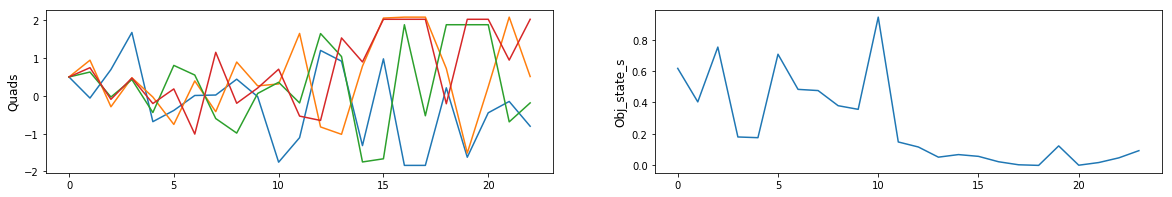

In [9]:
Niter = 20
for i in range(Niter):
    clear_output(wait=True) 
    print ('iteration =', i)
    print ('current position:', mi.x, 'current objective value:', mi.getState()[1])
   
    Obj_state_s.append(mi.getState()[1][0])
    
    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.set_ylabel('Quads',fontsize=12)
    ax.plot(opt.X_obs)
    ax2.set_ylabel('Obj_state_s',fontsize=12)
    ax2.plot(Obj_state_s)
    plt.show(); 
    
    opt.OptIter()
    time.sleep(acquisition_delay)
    time.sleep(0.1)

In [13]:
#save results if desired
if saveResultsQ == True:
    timestr = datetime.now().strftime('%Y-%m-%d-%H%M%S')
    try: os.mkdir('saved_results')
    except: pass
    results = {}
    results['scan_params'] = scan_params
    results['xs'] = opt.X_obs
    results['ys'] = np.array([y[0][0] for y in opt.Y_obs])
    results['time'] = timestr
    np.save('saved_results/scan_'+timestr, results)